In [21]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

In [22]:
train_size = int(20000 * 0.8)
validation_size = int(20000 * 0.2)

def generate_dataset(size, begin, end):
    x = torch.FloatTensor(size).uniform_(begin, end)
    y = torch.FloatTensor(size).uniform_(begin, end)
    return torch.utils.data.TensorDataset(x, x)

def F(x,y):
    return torch.sin(x + 2 * y) * torch.exp(-(2 * x + y) ** 2)

title = ' $ sin(x + 2*y)exp(-(2x + y)^2) $'

# Train dataset

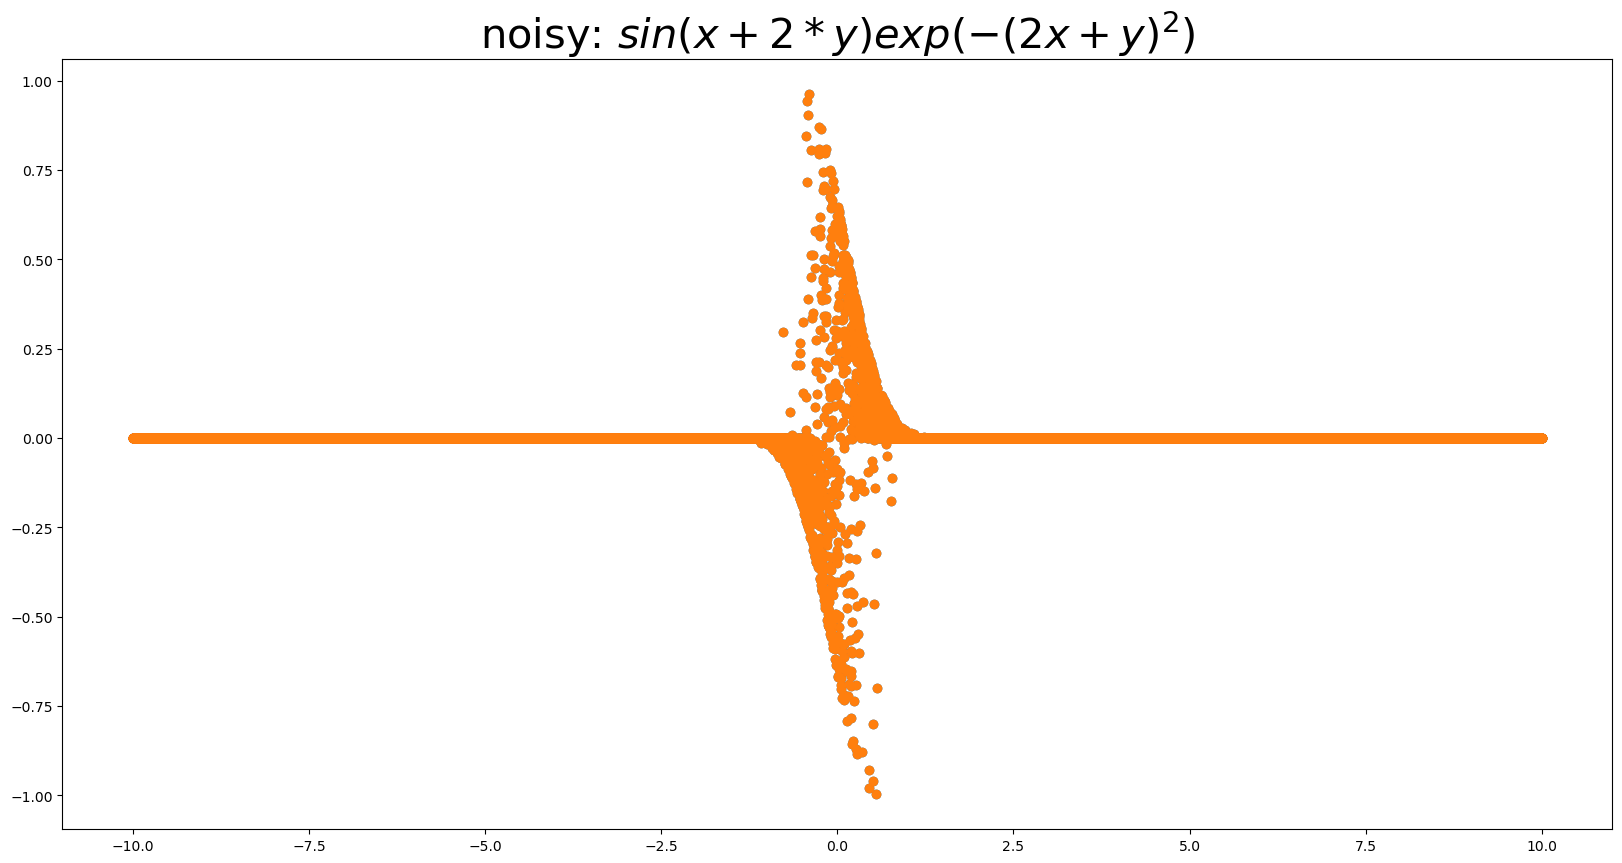

In [47]:
dataset_train = generate_dataset(train_size, -10, 10)
x_train = dataset_train.tensors[0]
y_train = dataset_train.tensors[1]
noise = torch.randn(y_train.shape) / 2.
y_train = y_train + noise
result_train = F(x_train, y_train)
plt.title('noisy:' + title, fontsize=30,)
plt.plot(dataset_train, result_train, 'o');

# Validation dataset

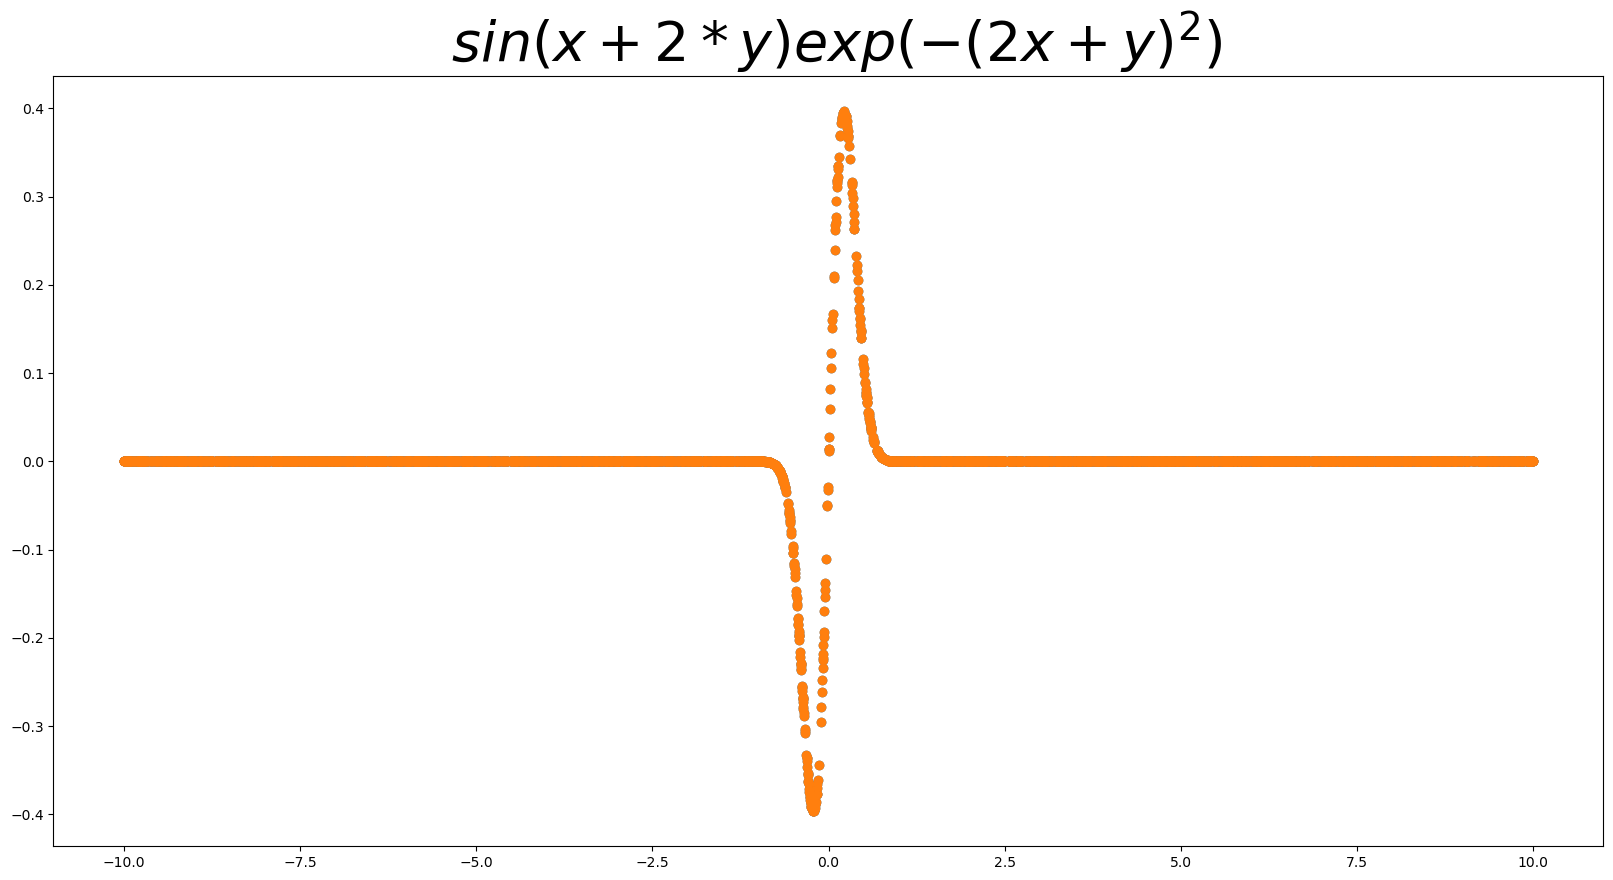

In [41]:
dataset_validation = generate_dataset(validation_size, -10, 10)
x_validation = dataset_validation.tensors[0]
y_validation = dataset_validation.tensors[1]
result_validation = F(x_validation, y_validation)
plt.title(title, fontsize=40,)
plt.plot(dataset_validation, result_validation, 'o');


In [42]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


# Model 

In [43]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size=32, output_size=1):
        super(NeuralNetwork, self).__init__()
#         self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.relu = nn.ReLU(inplace=True)
        self.output = nn.Linear(32, output_size)

    def forward(self, x):
#         x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        logits = self.output(x)
        
        return logits


model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (fc1): Linear(in_features=32, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (relu): ReLU(inplace=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
)


# Training

In [51]:
# Функция для обучения модели:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Делаем предсказания:
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
            
# Функция для тестирования обученной модели:
def test(dataloader, model, loss_fn, verbose=True, iterations=None):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for i, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(0) == y).type(torch.float).sum().item()
            if iterations is not None and i >= iterations:
                break
            
    test_loss /= num_batches
    correct /= size
    if verbose:
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")  

In [52]:
# Задаем гипперпараметры:
epochs = 10
batch_size = 32
lr = 0.01

# Инициализируем модель и data loaders:
model = NeuralNetwork().to(device)
train_dataloader = DataLoader(dataset_train, batch_size=batch_size)
test_dataloader = DataLoader(dataset_validation, batch_size=batch_size)


# Выбираем функцию потерь и оптимайзер:
loss_fn = nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))

# Обучаем 5 эпох (эпоха - один проход по всем данным):
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 27.392044  [    0/16000]
loss: 22.338230  [ 3200/16000]
loss: 27.173603  [ 6400/16000]
loss: 29.831131  [ 9600/16000]
loss: 19.355995  [12800/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 32.330011 

Epoch 2
-------------------------------
loss: 20.851009  [    0/16000]
loss: 22.355974  [ 3200/16000]
loss: 27.289385  [ 6400/16000]
loss: 29.635151  [ 9600/16000]
loss: 18.913116  [12800/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 32.259195 

Epoch 3
-------------------------------
loss: 20.519690  [    0/16000]
loss: 22.343636  [ 3200/16000]
loss: 27.174843  [ 6400/16000]
loss: 29.594418  [ 9600/16000]
loss: 19.215193  [12800/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 32.262410 

Epoch 4
-------------------------------
loss: 20.467964  [    0/16000]
loss: 22.341919  [ 3200/16000]
loss: 27.187340  [ 6400/16000]
loss: 29.479435  [ 9600/16000]
loss: 18.939842  [12800/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 32.542176 

Epoch 5
----